In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, make_scorer, brier_score_loss
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [3]:
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

In [4]:
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_non_penalty = df[~mask_penalty].copy()

In [5]:
def split(X):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    return X_pass, X_other

In [6]:
df_np_pass,  df_np_other = split(df_non_penalty)

In [7]:
df_np_pass = pd.get_dummies(df_np_pass, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                 'shot_type_name', 'body_part_name','pass_technique_name','pass_height_name'])
df_np_other = pd.get_dummies(df_np_other, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                   'assist_type','shot_type_name', 'body_part_name'])
y_np_pass = df_np_pass['goal']
x_np_pass = df_np_pass.drop(['goal'], axis=1)
x_npp_train, x_npp_test, y_npp_train, y_npp_test = train_test_split(x_np_pass, y_np_pass, test_size=0.2, random_state=42,
                                                                    stratify=y_np_pass)
y_np_other = df_np_other['goal']
x_np_other = df_np_other.drop(['goal'], axis=1)
x_npo_train, x_npo_test, y_npo_train, y_npo_test = train_test_split(x_np_other, y_np_other, test_size=0.2, random_state=42,
                                                                   stratify=y_np_other)

In [8]:
print('Shots pass train', len(y_npp_train), ';Number goals', y_npp_train.sum(),
      ';Goals %: ', round(y_npp_train.mean()*100, 1))
print('Shots pass test', len(y_npp_test), ';Number goals', y_npp_test.sum(),
      ';Goals %: ', round(y_npp_test.mean()*100, 1))

Shots pass train 35198 ;Number goals 3860 ;Goals %:  11.0
Shots pass test 8800 ;Number goals 965 ;Goals %:  11.0


In [9]:
print('Shots other train', len(y_npo_train), ';Number goals', y_npo_train.sum(),
      ';Goals %: ', round(y_npo_train.mean()*100, 1))
print('Shots other test', len(y_npo_test), ';Number goals', y_npo_test.sum(),
      ';Goals %: ', round(y_npo_test.mean()*100, 1))

Shots other train 16406 ;Number goals 1618 ;Goals %:  9.9
Shots other test 4102 ;Number goals 404 ;Goals %:  9.8


In [10]:
logreg = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, max_iter=100, multi_class='multinomial')
rfe_npp = RFE(logreg, 24)
rfe_npp = rfe_npp.fit(x_npp_train, y_npp_train)

x_npp_train = x_npp_train.loc[:, rfe_npp.support_]
x_npp_test = x_npp_test.loc[:, rfe_npp.support_]

In [11]:
sc = StandardScaler()
x_npp_train_sc = sc.fit_transform(x_npp_train)
x_npp_test_sc = sc.fit_transform(x_npp_test)

In [12]:
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, max_iter=100, multi_class='multinomial')

In [13]:
grid={"C": np.logspace(-3,3,7)}

In [14]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npp.fit(x_npp_train_sc, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc.astype(float))

In [15]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2895
The ROC AUC of our non-penalty pass model on the training set is : 0.7843
McFadden's Pseudo R-squared shots assisted by passes : 0.1629


In [16]:
rfe_npo = RFE(logreg, 24)
rfe_npo = rfe_npo.fit(x_npo_train, y_npo_train)

x_npo_train = x_npo_train.loc[:, rfe_npo.support_]
x_npo_test = x_npo_test.loc[:, rfe_npo.support_]

In [17]:
sc = StandardScaler()
x_npo_train_sc = sc.fit_transform(x_npo_train)
x_npo_test_sc = sc.fit_transform(x_npo_test)

In [18]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_npo.fit(x_npo_train_sc, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc.astype(float))

In [19]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2595
The ROC AUC of our non-penalty other model on the training set is : 0.8061
McFadden's Pseudo R-squared shots assisted by passes : 0.1629


In [20]:
logreg = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, max_iter=100, multi_class='multinomial')
rfe_npp2 = RFE(logreg, 20)
rfe_npp2 = rfe_npp2.fit(x_npp_train, y_npp_train)

x_npp_train2 = x_npp_train.loc[:, rfe_npp2.support_]
x_npp_test2 = x_npp_test.loc[:, rfe_npp2.support_]

In [21]:
sc = StandardScaler()
x_npp_train_sc2 = sc.fit_transform(x_npp_train2)
x_npp_test_sc2 = sc.fit_transform(x_npp_test2)

In [22]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_npp.fit(x_npp_train_sc2, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc2.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc2.astype(float))

In [23]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2897
The ROC AUC of our non-penalty pass model on the training set is : 0.7841
McFadden's Pseudo R-squared shots assisted by passes : 0.1621


In [24]:
freg=f_regression(x_npp_train_sc2, y_npp_train)
p=freg[1]
print(p.round(3))

[0.    0.017 0.067 0.    0.    0.002 0.    0.    0.005 0.006 0.009 0.
 0.54  0.088 0.001 0.256 0.383 0.    0.    0.037]


In [25]:
rfe_npo2 = RFE(logreg, 20)
rfe_npo2 = rfe_npo2.fit(x_npo_train, y_npo_train)

x_npo_train2 = x_npo_train.loc[:, rfe_npo2.support_]
x_npo_test2 = x_npo_test.loc[:, rfe_npo2.support_]

In [26]:
sc = StandardScaler()
x_npo_train_sc2 = sc.fit_transform(x_npo_train2)
x_npo_test_sc2 = sc.fit_transform(x_npo_test2)

In [27]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_npo.fit(x_npo_train_sc2, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc2.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc2.astype(float))

In [28]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2597
The ROC AUC of our non-penalty other model on the training set is : 0.8062
McFadden's Pseudo R-squared shots assisted by passes : 0.1621


In [29]:
logreg = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, max_iter=100, multi_class='multinomial')
rfe_npp3 = RFE(logreg, 11)
rfe_npp3 = rfe_npp3.fit(x_npp_train, y_npp_train)

x_npp_train3 = x_npp_train.loc[:, rfe_npp3.support_]
x_npp_test3 = x_npp_test.loc[:, rfe_npp3.support_]

In [30]:
sc = StandardScaler()
x_npp_train_sc3 = sc.fit_transform(x_npp_train3)
x_npp_test_sc3 = sc.fit_transform(x_npp_test3)

In [31]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_npp.fit(x_npp_train_sc3, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc3.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc3.astype(float))

Wall time: 2.38 s


In [32]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2903
The ROC AUC of our non-penalty pass model on the training set is : 0.783
McFadden's Pseudo R-squared shots assisted by passes : 0.1605


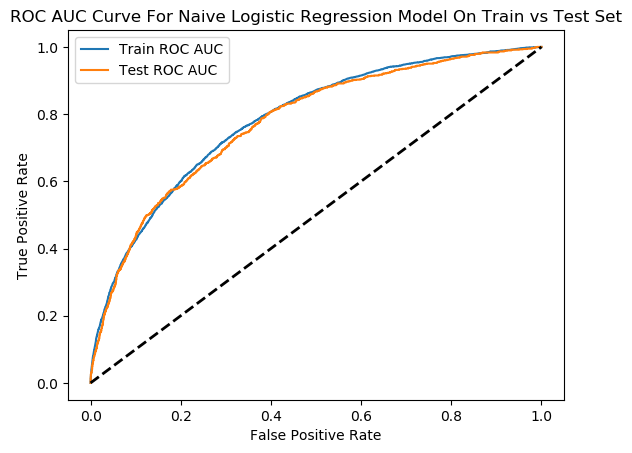

In [33]:
plt.style.use('default')
train_npp_fpr, train_npp_tpr, train_npp_thresholds = roc_curve(y_true=y_npp_train, y_score=train_y_npp_hat[:,1])
test_npp_fpr, test_npp_tpr, test_npp_thresholds = roc_curve(y_true=y_npp_test, y_score=y_pred_lr_npp[:,1])
plt.plot(train_npp_fpr, train_npp_tpr, label = 'Train ROC AUC')
plt.plot(test_npp_fpr, test_npp_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [34]:
freg=f_regression(x_npp_train_sc3, y_npp_train)
p=freg[1]
print(p.round(3))

[0.    0.067 0.    0.    0.    0.006 0.009 0.088 0.383 0.    0.037]


In [35]:
rfe_npo3 = RFE(logreg, 13)
rfe_npo3 = rfe_npo3.fit(x_npo_train, y_npo_train)

x_npo_train3 = x_npo_train.loc[:, rfe_npo3.support_]
x_npo_test3 = x_npo_test.loc[:, rfe_npo3.support_]

In [36]:
sc = StandardScaler()
x_npo_train_sc3 = sc.fit_transform(x_npo_train3)
x_npo_test_sc3 = sc.fit_transform(x_npo_test3)

In [37]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_npo.fit(x_npo_train_sc3, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc3.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc3.astype(float))

Wall time: 1.5 s


In [38]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2605
The ROC AUC of our non-penalty other model on the training set is : 0.8043
McFadden's Pseudo R-squared shots assisted by passes : 0.1605


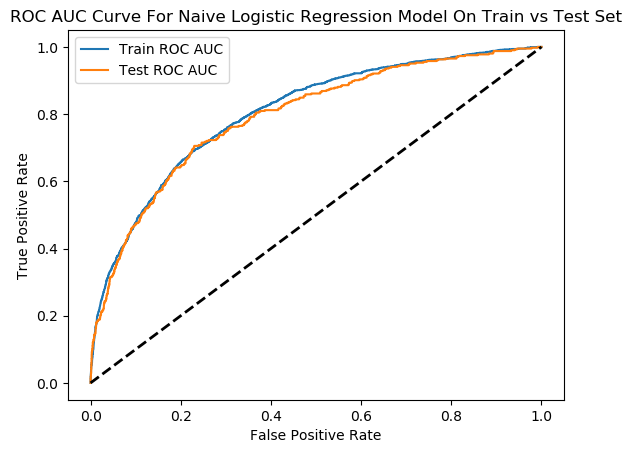

In [39]:
test_y_npo_hat = logistic_regression_npo.predict(x_npo_test3.astype(float))
train_npo_fpr, train_npo_tpr, train_npo_thresholds = roc_curve(y_true=y_npo_train, y_score=train_y_npo_hat[:,1])
test_npo_fpr, test_npo_tpr, test_npo_thresholds = roc_curve(y_true=y_npo_test, y_score=y_pred_lr_npo[:,1])
plt.plot(train_npo_fpr, train_npo_tpr, label = 'Train ROC AUC')
plt.plot(test_npo_fpr, test_npo_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [40]:
freg=f_regression(x_npo_train_sc3, y_npo_train)
p=freg[1]
print(p.round(3))

[0.    0.073 0.    0.    0.    0.    0.029 0.    0.    0.018 0.    0.891
 0.   ]


# LightGBM

Load the data

In [41]:
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df2.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df2.shot_type_name=='penalty')
df_non_penalty = df2[~mask_penalty].copy()
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

Split into train, calibration and test datasets

In [42]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [43]:
print('Shots train', len(y_train_lgbm), ';Number goals', y_train_lgbm.sum(),
      ';Goals %: ', round(y_train_lgbm.mean()*100, 1))
print('Shots test', len(y_test_lgbm), ';Number goals', y_test_lgbm.sum(),
      ';Goals %: ', round(y_test_lgbm.mean()*100, 1))

Shots train 51604 ;Number goals 5478 ;Goals %:  10.6
Shots test 12902 ;Number goals 1369 ;Goals %:  10.6


Load and split fake data

In [44]:
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.drop(['competition_gender','competition_gender','match_week'], axis=1, inplace=True)
df_fake.index = ['a'+str(idx) for idx in df_fake.index]

y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [45]:
print('Shots fake', len(y_fake), ';Goals %: ', round(y_fake.mean()*100, 1))

Shots fake 1000 ;Goals %:  3.4


Add fake training data. I am not adding this to the test data as want this to be realistic of real data.

In [46]:
X_train_lgbm = pd.concat([X_train_lgbm, X_fake])
y_train_lgbm = pd.concat([y_train_lgbm, y_fake])

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [47]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train_lgbm = clean_lightgbm(X_train_lgbm)
X_test_lgbm = clean_lightgbm(X_test_lgbm)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [48]:
lgbm = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', cv=3)
lgbm_param_grid = {'base_estimator__min_child_samples': Integer(0, 200),
                   'base_estimator__num_leaves': Integer(2, 500),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 500)}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [49]:
searchcv_lgbm = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
%time searchcv_lgbm.fit(X_train_lgbm, y_train_lgbm)
y_pred_lgbm = searchcv_lgbm.best_estimator_.predict_proba(X_test_lgbm)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Wall time: 28min 9s


Permutation importance

In [50]:
perm_result = permutation_importance(searchcv_lgbm.best_estimator_, X_train_lgbm, y_train_lgbm, n_repeats=10, random_state=42)
df_perm_importance = pd.DataFrame({'Feature':X_train_lgbm.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

,Feature,importance,std_dev
0,visible_angle,7.626796e-03,0.000238
1,distance_to_goal,6.896814e-03,0.000239
2,body_part_name,1.408638e-03,0.000203
3,x,1.366816e-03,0.000154
4,n_angle,1.319291e-03,0.000174
5,goalkeeper_x,9.352901e-04,0.000130
6,shot_type_name,8.155273e-04,0.000205
7,y,7.946164e-04,0.000157
8,area_shot,7.737054e-04,0.000170
9,distance_visible_angle,6.558437e-04,0.000119


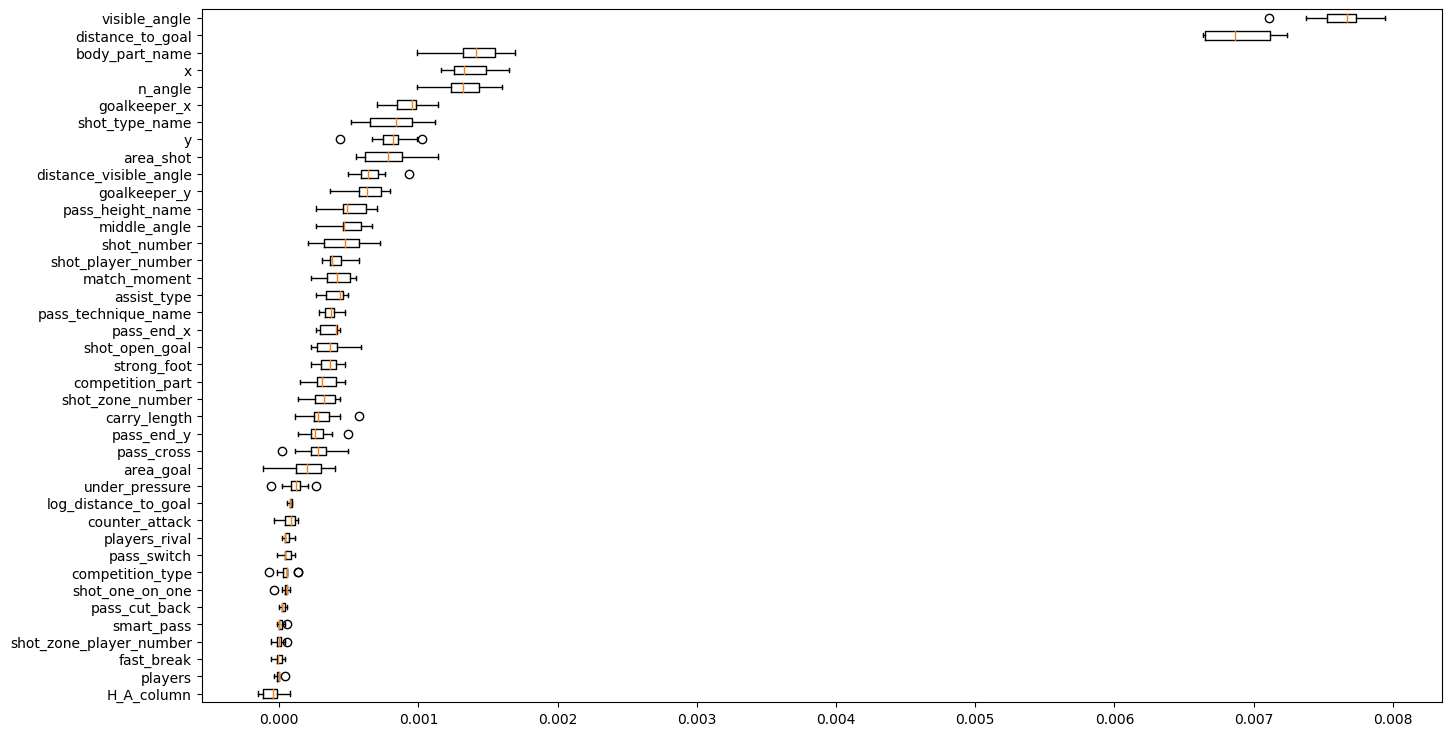

In [51]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train_lgbm.columns[sorted_idx])

# XGBoost

Same process of splitting, adding data fake and cleaning of the LightGBM model.

In [52]:
df3 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df3.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df3.shot_type_name=='penalty')
df_non_penalty = df3[~mask_penalty].copy()
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [53]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [54]:
X_train_xgb = pd.concat([X_train_xgb, X_fake])
y_train_xgb = pd.concat([y_train_xgb, y_fake])

In [55]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train_xgb = clean_lightgbm(X_train_xgb)
X_test = clean_lightgbm(X_test)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [56]:
xgb = CalibratedClassifierCV(XGBClassifier(random_state=42, eval_metric='logloss'), method='isotonic', cv=3)
xgb_param_grid = {'base_estimator__min_child_weight': Integer(0, 50),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 10)}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [57]:
searchcv_xgb = BayesSearchCV(estimator=xgb,
                             n_iter=100,
                             search_spaces=xgb_param_grid,
                             cv=5,
                             n_jobs=-1)
%time searchcv_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = searchcv_xgb.best_estimator_.predict_proba(X_test)

Wall time: 55min 14s


Permutation importance

In [58]:
perm_result_xgb = permutation_importance(searchcv_xgb.best_estimator_, X_train_xgb, y_train_xgb, n_repeats=10, random_state=42)
df_perm_importance_xgb = pd.DataFrame({'Feature':X_train_xgb.columns,
                                   'importance': perm_result_xgb.importances.mean(axis=1),
                                   'std_dev': perm_result_xgb.importances.std(axis=1)})
df_perm_importance_xgb.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_xgb.reset_index(drop=True, inplace=True)
df_perm_importance_xgb

,Feature,importance,std_dev
0,visible_angle,0.006024,0.000253
1,distance_to_goal,0.004648,0.000223
2,body_part_name,0.001376,0.000165
3,goalkeeper_x,0.000909,0.000108
4,n_angle,0.000774,0.000148
5,shot_type_name,0.000587,0.000212
6,shot_open_goal,0.000397,0.000137
7,area_goal,0.000346,0.000040
8,pass_end_x,0.000281,0.000093
9,x,0.000268,0.000171


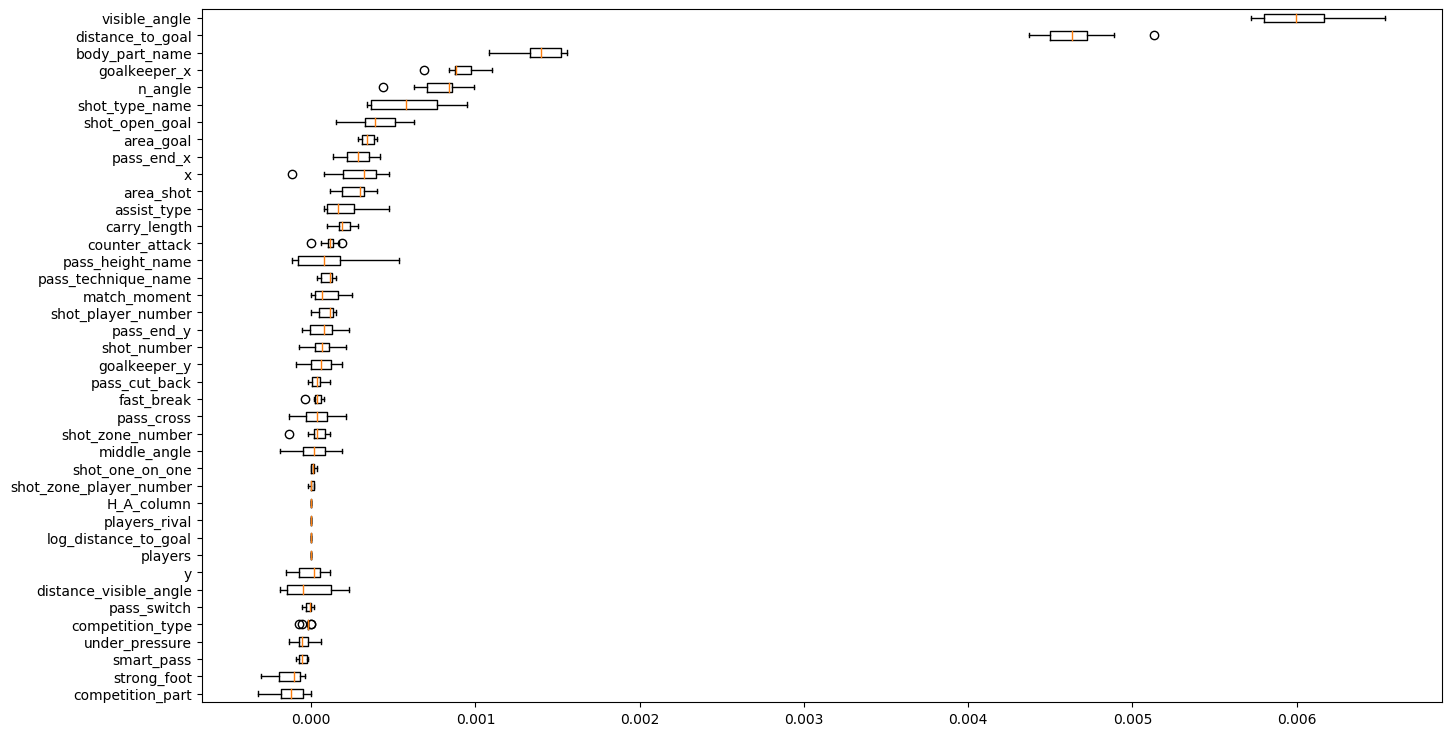

In [59]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_xgb.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_xgb.importances[sorted_idx].T, vert=False, labels=X_train_xgb.columns[sorted_idx])

# Random Forest

Same process of splitting and generation of dummy variables of the Logistic Regression model.

In [60]:
cwd = os.getcwd()
df4 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df4.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df4.shot_type_name=='penalty')
df_non_penalty_rf = df4[~mask_penalty].copy()

In [61]:
def split(X):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    return X_pass, X_other

In [62]:
df_np_pass_rf,  df_np_other_rf = split(df_non_penalty_rf)

In [63]:
df_np_pass_rf = pd.get_dummies(df_np_pass_rf, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                 'shot_type_name', 'body_part_name','pass_technique_name','pass_height_name'])
df_np_other_rf = pd.get_dummies(df_np_other_rf, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                   'assist_type','shot_type_name', 'body_part_name'])
y_np_pass_rf = df_np_pass_rf['goal']
x_np_pass_rf = df_np_pass_rf.drop(['goal'], axis=1)
x_npp_train_rf, x_npp_test_rf, y_npp_train_rf, y_npp_test_rf = train_test_split(x_np_pass_rf, y_np_pass_rf, train_size=0.8,
                                                                                random_state=42, stratify=y_np_pass_rf)
y_np_other_rf = df_np_other_rf['goal']
x_np_other_rf = df_np_other_rf.drop(['goal'], axis=1)
x_npo_train_rf, x_npo_test_rf, y_npo_train_rf, y_npo_test_rf = train_test_split(x_np_other_rf, y_np_other_rf, train_size=0.8,
                                                                                random_state=42, stratify=y_np_other_rf)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [64]:
rf = CalibratedClassifierCV(RandomForestClassifier(random_state=42), method='isotonic', cv=3)
rf_param_grid = {'base_estimator__n_estimators': [100, 500],
                   'base_estimator__max_features': ['auto'],
                   'base_estimator__min_samples_leaf': [1, 5, 20, 100],
                   'base_estimator__min_samples_split': [2, 10, 50, 250],
                   'base_estimator__criterion': ["gini", "entropy"],
                   'base_estimator__max_depth': [4, 6, 8, 10, None]
}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [65]:
searchcv_rf_npp = BayesSearchCV(estimator=rf,
                                 n_iter=100,
                                 search_spaces=rf_param_grid,
                                 cv=5,
                                 n_jobs=-1)
%time searchcv_rf_npp.fit(x_npp_train_rf, y_npp_train_rf)
y_pred_rf_npp = searchcv_rf_npp.best_estimator_.predict_proba(x_npp_test_rf)

Wall time: 1h 5min 16s


Permutation importance

In [66]:
perm_result_rf_npp = permutation_importance(searchcv_rf_npp.best_estimator_, x_npp_train_rf, y_npp_train_rf, n_repeats=10,
                                     random_state=42)
df_perm_importance_rf_npp = pd.DataFrame({'Feature':x_npp_train_rf.columns,
                                   'importance': perm_result_rf_npp.importances.mean(axis=1),
                                   'std_dev': perm_result_rf_npp.importances.std(axis=1)})
df_perm_importance_rf_npp.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_rf_npp.reset_index(drop=True, inplace=True)
df_perm_importance_rf_npp

,Feature,importance,std_dev
0,visible_angle,0.004165,0.000144
1,log_distance_to_goal,0.004068,0.000167
2,distance_to_goal,0.003682,0.000177
3,x,0.001952,0.000243
4,y,0.001122,0.000125
5,pass_height_name_Ground/ Low Pass,0.001003,0.000096
6,pass_height_name_High Pass,0.000977,0.000081
7,body_part_name_Other,0.000963,0.000181
8,distance_visible_angle,0.000864,0.000175
9,body_part_name_Left Foot,0.000736,0.000184


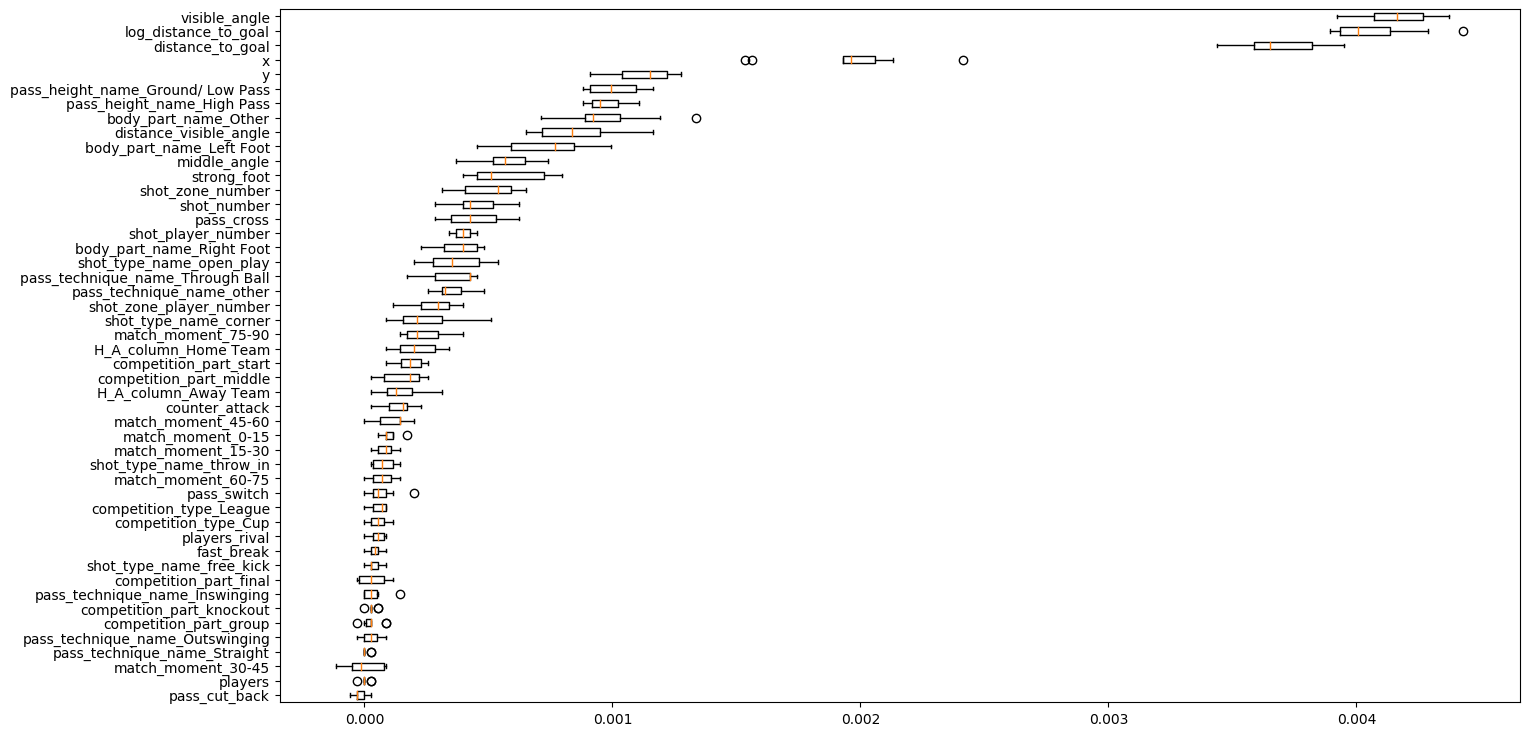

In [67]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_rf_npp.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_rf_npp.importances[sorted_idx].T, vert=False, labels=x_npp_train_rf.columns[sorted_idx])

Same process for other shots.

In [68]:
searchcv_rf_npo = BayesSearchCV(estimator=rf,
                                 n_iter=100,
                                 search_spaces=rf_param_grid,
                                 cv=5,
                                 n_jobs=-1)
%time searchcv_rf_npo.fit(x_npo_train_rf, y_npo_train_rf)
y_pred_rf_npo = searchcv_rf_npo.best_estimator_.predict_proba(x_npo_test_rf)

Wall time: 32min 14s


In [69]:
perm_result_rf_npo = permutation_importance(searchcv_rf_npo.best_estimator_, x_npo_train_rf, y_npo_train_rf, n_repeats=10,
                                     random_state=42)
df_perm_importance_rf_npo = pd.DataFrame({'Feature':x_npo_train_rf.columns,
                                   'importance': perm_result_rf_npo.importances.mean(axis=1),
                                   'std_dev': perm_result_rf_npo.importances.std(axis=1)})
df_perm_importance_rf_npo.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_rf_npo.reset_index(drop=True, inplace=True)
df_perm_importance_rf_npo

,Feature,importance,std_dev
0,visible_angle,1.080702e-02,0.000378
1,log_distance_to_goal,1.025235e-02,0.000283
2,distance_to_goal,9.923199e-03,0.000255
3,x,6.058759e-03,0.000591
4,y,1.700597e-03,0.000305
5,shot_number,1.371449e-03,0.000197
6,shot_type_name_open_play,1.371449e-03,0.000286
7,middle_angle,1.249543e-03,0.000277
8,shot_zone_number,1.158113e-03,0.000253
9,assist_type_rebound,1.152018e-03,0.000132


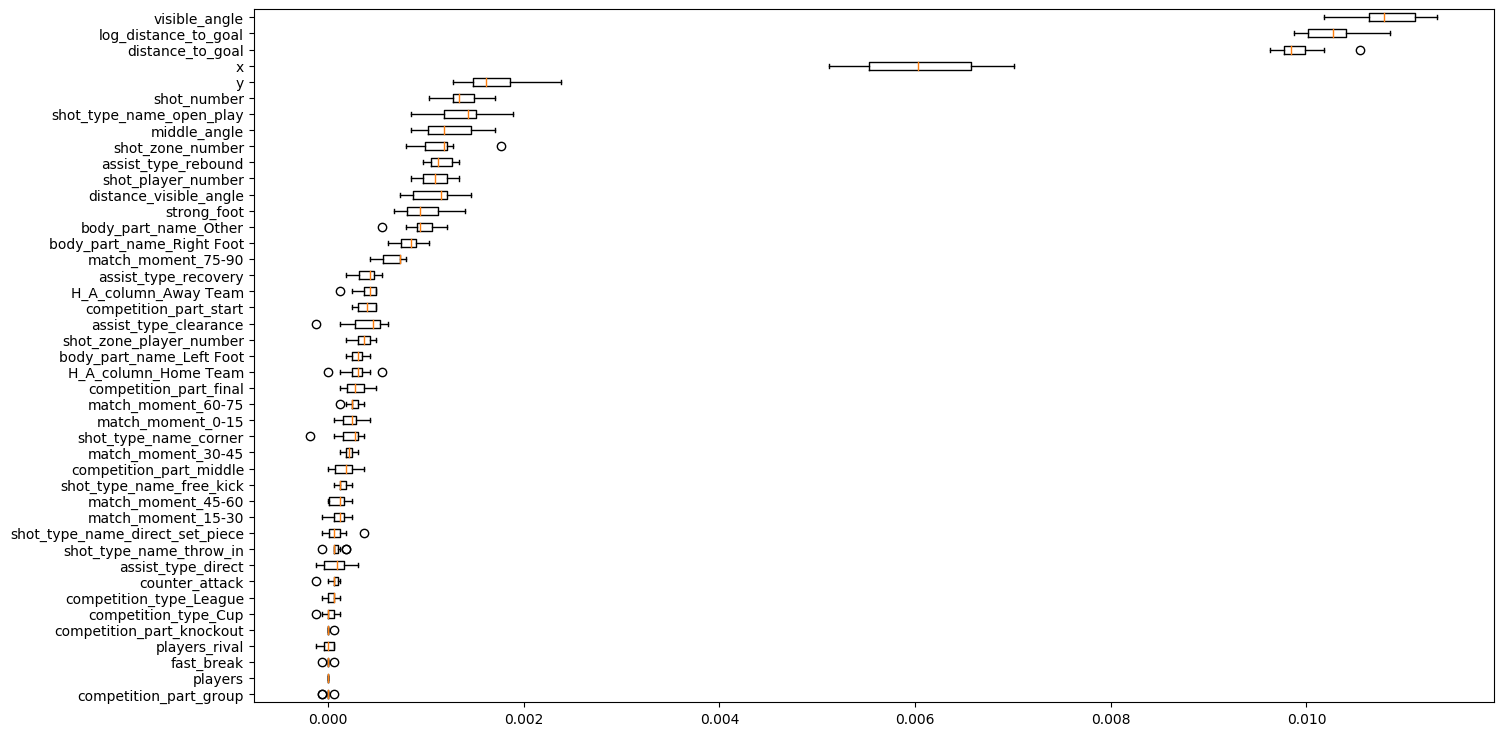

In [70]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_rf_npo.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_rf_npo.importances[sorted_idx].T, vert=False, labels=x_npo_train_rf.columns[sorted_idx])

# Test

In [71]:
# Calculate calibration curve on test data for non-penalty shots
# logistic regression
y_pred_lr = np.concatenate([y_pred_lr_npp, y_pred_lr_npo])
y_true_test_lr = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test_lr, y_pred_lr[:,1], n_bins=50,
                                                                      strategy='quantile')
# LightGBM
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test_lgbm, y_pred_lgbm[:, 1], n_bins=50,
                                                                          strategy='quantile')
# XGBoost
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_test_xgb, y_pred_xgb[:, 1], n_bins=50,
                                                                        strategy='quantile')
# Random Forest
y_pred_rf = np.concatenate([y_pred_rf_npp, y_pred_rf_npo])
y_true_test_rf = np.concatenate([y_npp_test_rf, y_npo_test_rf])
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_true_test_rf, y_pred_rf[:,1], n_bins=50,
                                                                      strategy='quantile')

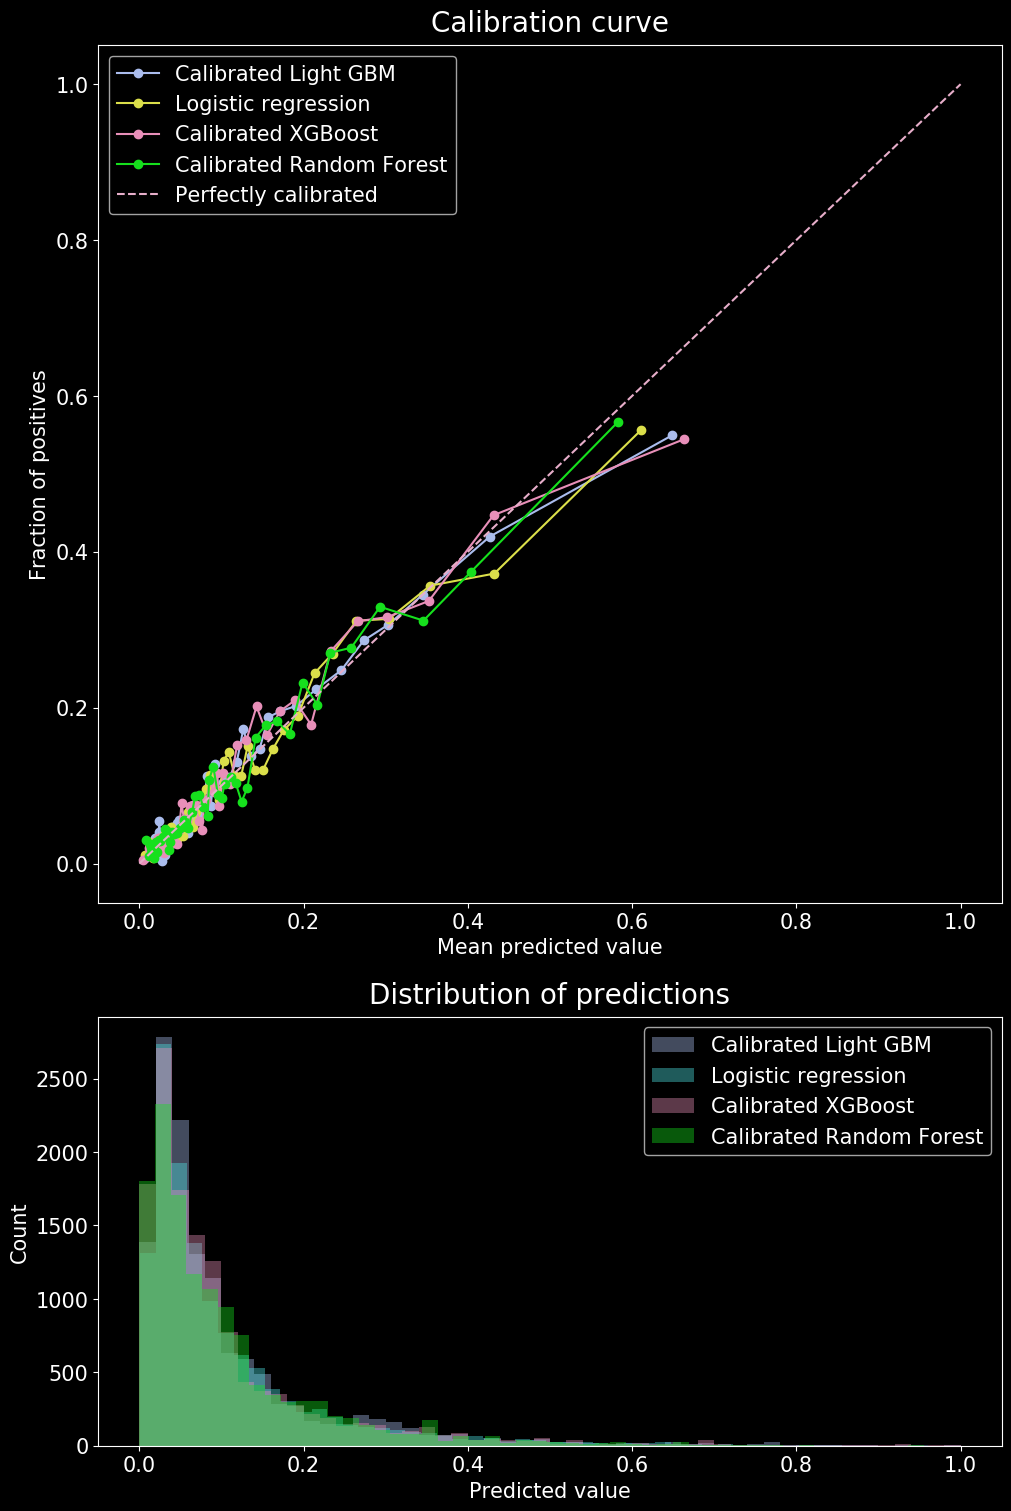

In [72]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, "-o", color='#e88fb9', label='Calibrated XGBoost')
ax1.plot(mean_predicted_value_rf, fraction_of_positives_rf, "-o", color='#16e01d', label='Calibrated Random Forest')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
sns.distplot(y_pred_lr[:,1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
sns.distplot(y_pred_xgb[:,1], color='#e88fb9', label='Calibrated XGBoost', kde=False, ax=ax2)
sns.distplot(y_pred_rf[:, 1], color='#16e01d', label='Calibrated Random Forest', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve2.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [73]:
print("The log loss of the non-penalty model with Logistic Regression is: " + str(log_loss(y_true_test_lr, y_pred_lr[:,1])))
print("The ROC AUC score of the non-penalty model with Logistic Regression is: " +str(roc_auc_score(y_true_test_lr,
                                                                                                    y_pred_lr[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with Logistic Regression is:', mcfadden_r2(y_true_test_lr,
                                                                                                    y_pred_lr[:,1]))
print('The Brier score of the non-penalty model with Logistic Regression is:',brier_score_loss(y_true_test_lr, y_pred_lr[:,1],
                                                                                         pos_label=y_true_test_lr.max()))

The log loss of the non-penalty model with Logistic Regression is: 0.284716755433132
The ROC AUC score of the non-penalty model with Logistic Regression is: 0.781641869043239
The McFaddens Pseudo R-squared of the non-penalty model with Logistic Regression is: 0.1583874894540973
The Brier score of the non-penalty model with Logistic Regression is: 0.08216415879530918


In [74]:
print("The log loss of the non-penalty model with LightGBM is: " + str(log_loss(y_test_lgbm, y_pred_lgbm)))
print("The ROC AUC score of the non-penalty model with LightGBM is: " +str(roc_auc_score(y_test_lgbm, y_pred_lgbm[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with LightGBM is:', mcfadden_r2(y_test_lgbm, y_pred_lgbm[:,1]))
print('The Brier score of the non-penalty model with LightGBM is:',brier_score_loss(y_test_lgbm, y_pred_lgbm[:,1],
                                                                                    pos_label=y_test_lgbm.max()))

The log loss of the non-penalty model with LightGBM is: 0.2852652593379159
The ROC AUC score of the non-penalty model with LightGBM is: 0.7862337357335261
The McFaddens Pseudo R-squared of the non-penalty model with LightGBM is: 0.15676613159741926
The Brier score of the non-penalty model with LightGBM is: 0.08180974382686533


In [75]:
print("The log loss of the non-penalty model with XGBoost is: " + str(log_loss(y_test_xgb, y_pred_xgb)))
print("The ROC AUC score of the non-penalty model with XGBoost is: " +str(roc_auc_score(y_test_xgb, y_pred_xgb[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with XGBoost is:', mcfadden_r2(y_test_xgb, y_pred_xgb[:,1]))
print('The Brier score of the non-penalty model with XGBoost is:',brier_score_loss(y_test_xgb, y_pred_xgb[:,1],
                                                                                    pos_label=y_test_xgb.max()))

The log loss of the non-penalty model with XGBoost is: 0.280801614495046
The ROC AUC score of the non-penalty model with XGBoost is: 0.79243628202667
The McFaddens Pseudo R-squared of the non-penalty model with XGBoost is: 0.16996050555225772
The Brier score of the non-penalty model with XGBoost is: 0.08135450891160453


In [76]:
print("The log loss of the non-penalty model with Random Forest is: " + str(log_loss(y_true_test_rf, y_pred_rf)))
print("The ROC AUC score of the non-penalty model with Random Forest is: " +str(roc_auc_score(y_true_test_rf, y_pred_rf[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with Random Forest is:', mcfadden_r2(y_true_test_rf,
                                                                                                   y_pred_rf[:,1]))
print('The Brier score of the non-penalty model with Random Forest is:',brier_score_loss(y_true_test_rf, y_pred_rf[:,1],
                                                                                    pos_label=y_true_test_rf.max()))

The log loss of the non-penalty model with Random Forest is: 0.285772028140155
The ROC AUC score of the non-penalty model with Random Forest is: 0.7792497750128146
The McFaddens Pseudo R-squared of the non-penalty model with Random Forest is: 0.1552681412059862
The Brier score of the non-penalty model with Random Forest is: 0.08241811288631282


# Save models

In [77]:
dump(logistic_regression_npp, os.path.join(cwd, 'models', 'lr_model_pass.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_model_pass.joblib']

In [78]:
dump(logistic_regression_npo, os.path.join(cwd, 'models', 'lr_model_other.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_model_other.joblib']

In [79]:
dump(searchcv_lgbm.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lgbm_model.joblib']

In [80]:
dump(searchcv_xgb.best_estimator_, os.path.join(cwd, 'models', 'xgb_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model.joblib']

In [81]:
dump(searchcv_rf_npp.best_estimator_, os.path.join(cwd, 'models', 'rf_model_pass.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\rf_model_pass.joblib']

In [82]:
dump(searchcv_rf_npo.best_estimator_, os.path.join(cwd, 'models', 'rf_model_other.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\rf_model_other.joblib']

# Save data

In [83]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [84]:
x_npp_train3['goal'] = y_npp_train
x_npp_train3['split'] = 'train'
x_npp_test3['goal'] = y_npp_test
x_npp_test3['split'] = 'test'
df_pass = pd.concat([x_npp_train3, x_npp_test3])
df_pass = df_pass.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_pass.reset_index(drop=True, inplace=True)
df_pass.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_pass.parquet'))

x_npo_train3['goal'] = y_npo_train
x_npo_train3['split'] = 'train'
x_npo_test3['goal'] = y_npo_test
x_npo_test3['split'] = 'test'
df_other = pd.concat([x_npo_train3, x_npo_test3])
df_other = df_other.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_other.reset_index(drop=True, inplace=True)
df_other.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_other.parquet'))

In [85]:
# reload shot dataset for ids
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df2.shot_type_name=='penalty')
df_non_penalty2 = df2[~mask_penalty].copy()
df_non_penalty2 = df_non_penalty2[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [86]:
X_train_lgbm['goal'] = y_train_lgbm
X_train_lgbm['split'] = 'train'
X_test_lgbm['goal'] = y_test_lgbm
X_test_lgbm['split'] = 'test'
df_lgbm = pd.concat([X_train_lgbm, X_test_lgbm])
# exlcude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df_non_penalty2.index)].copy()
df_lgbm = df_lgbm.merge(df_non_penalty2, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm.parquet'))

In [87]:
df3 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df3.shot_type_name=='penalty')
df_non_penalty3 = df3[~mask_penalty].copy()
df_non_penalty3 = df_non_penalty3[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [91]:
X_train_xgb['goal'] = y_train_xgb
X_train_xgb['split'] = 'train'
X_test_xg['goal'] = y_test_xgb
X_test_xg['split'] = 'test'
df_xgb = pd.concat([X_train_xgb, X_test_xg])
# exlcude fake shots
df_xgb = df_xgb[df_xgb.index.isin(df_non_penalty3.index)].copy()
df_xgb = df_xgb.merge(df_non_penalty3, how='left', left_index=True, right_index=True, validate='1:1')
df_xgb.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb.parquet'))

In [92]:
# reload shot dataset for ids
df4 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df4 = df4[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [93]:
x_npp_train_rf['goal'] = y_npp_train_rf
x_npp_train_rf['split'] = 'train'
x_npp_test_rf['goal'] = y_npp_test_rf
x_npp_test_rf['split'] = 'test'
df_pass4 = pd.concat([x_npp_train_rf, x_npp_test_rf])
df_pass4 = df_pass4.merge(df4, left_index=True, right_index=True, validate='1:1', how='left')
df_pass4.reset_index(drop=True, inplace=True)
df_pass4.to_parquet(os.path.join(cwd, 'data', 'modelling', 'rf_pass.parquet'))

x_npo_train_rf['goal'] = y_npo_train_rf
x_npo_train_rf['split'] = 'train'
x_npo_test_rf['goal'] = y_npo_test_rf
x_npo_test_rf['split'] = 'test'
df_other4 = pd.concat([x_npo_train_rf, x_npo_test_rf])
df_other4 = df_other4.merge(df4, left_index=True, right_index=True, validate='1:1', how='left')
df_other4.reset_index(drop=True, inplace=True)
df_other4.to_parquet(os.path.join(cwd, 'data', 'modelling', 'rf_other.parquet'))